
<center>
    <img src='./assets/images/besm.png' width='150px'>
</center>

In [1]:
%%html
<style>
    .jp-MarkdownOutput {
        direction: rtl;
        text-align: right;
        font-family: 'Vazir', 'B Nazanin', 'B Lotus', 'Arial', 'Verdana'
    }
    h4 {
        padding: 0px;
        margin: 0px;
    }
    div, span {
        font-size: 14px;
    }
</style>

<h3><center>تمرین نخست درس «پردازش زبان‌های طبیعی»</center></h3>
<h4><center> جواد راضی (۴۰۱۲۰۴۳۵۴) </center></h4>
<h4><center> ترم ۴۰۱۲ </center></h4>
<br>



<h2>
    متن انتخابی
</h2>
  

<span>
    در این تمرین، کامنت‌های زیر چند شعر مشهور در وب‌سایت گنجور استخراج شده، و بر روی آن‌ها یکسری پردازش اعمال می‌شود. 
</span>

<h2>
    کاوش متن و استخراج کامنت‌های سایت
</h2>
<div>
    <span>
        برای crawling، از ابزار scrapy در این تمرین استفاده شده‌است.
    </span>
    <span>
        scrapy، یک کتاب‌خانه پایتون است که به واسطه آن می‌توان اطلاعات مورد نظر، نظیر متون،‌تصاویر، و محتوای بخش‌های خاصی از سایت را از آن استخراج نمود. 
    </span>
    <br/>
    <span>
        اسکریپت پایتون زیر، یک کامنت‌های مربوط به چند شعر انتخابی از خیام، حافظ، و پروین اعتصامی را استخراج می‌نماید. کامنت‌های کراول شده، ساختاری nested دارند؛ به عبارت دیگر، برای هر شعر، کامنت‌‌ها خود می‌توانند شامل کامنت‌های پاسخ باشند که در قالب یک آبجکت nested ذخیره می‌شود.
    </span>
</div>

<h4>
    نصب پکیج‌های مورد نیاز
</h4>
<div>
    ابزار scrapy برای استخراج متن استفاده می‌شود. پکیج crochet نیز برای امکان اجرای crawling در پس‌زمینه، با ابزار ژوپیتر نصب شده‌است. با این کتابخانه، تا زمانی معین، scrapy داده‌ها را استخراج کرده و پس از آن با تایم‌آوت، اگر عملیات استخراج به پایان نرسیده، به پایان می‌رسد. این ابزار برای اجرای کد در محیط اینترکتیو ژوپیتر انتخاب شده‌است.  
</div>

In [2]:
try:
    import scrapy 
except: 
    !pip3 install scrapy
try:
    import crochet
except:
    !pip3 install crochet
try:
    import jsonlines
except:
    !pip3 install jsonlines

<h4>
    ایمپورت نیازمندی‌ها 
</h4>

In [3]:
import scrapy
from scrapy.crawler import CrawlerRunner
import re
from crochet import setup, wait_for, TimeoutError
import jsonlines

setup()


<h4>
    تولید آدرس‌ پیج‌های شعرای مورد نظر در سایت گنجور  
</h4>
<div>
    برای این تمرین، کامنت‌های حاشیه اشعار ۶ شاعر معروف پارسی‌زبان استخراج شده‌است.
</div>

In [4]:
MAJOR_POETS = {
    'khayyam': {
        'ganjoor_name': 'khayyam',
    },
    'hafez': {
        'ganjoor_name': 'hafez',
    },
    'moulavi': {
        'ganjoor_name': 'moulavi',
    },
    'ferdousi': {
        'ganjoor_name': 'ferdousi',
    },
    'nezami': {
        'ganjoor_name': 'nezami',
    },
    'saadi': {
        'ganjoor_name': 'saadi'
    }
}

GANJOOR_URL = 'https://ganjoor.net/'

def gen_start_urls():
    for poet in MAJOR_POETS.values():
        yield GANJOOR_URL + poet['ganjoor_name'] + '/'

list(gen_start_urls())

['https://ganjoor.net/khayyam/',
 'https://ganjoor.net/hafez/',
 'https://ganjoor.net/moulavi/',
 'https://ganjoor.net/ferdousi/',
 'https://ganjoor.net/nezami/',
 'https://ganjoor.net/saadi/']

<div>
    برای محدود کردن سایز دیتاست و تعداد درخواست‌ها، از هر شاعر، کامنت‌های مربوط به ۱۰۰ شعر نخست او استخراج می‌شود.  
</div>

In [5]:
LIMIT_POEM_PAGE_PER_POET = 300

global poems_crawled_per_poet
poems_crawled_per_poet = {}
for poet in MAJOR_POETS:
    poems_crawled_per_poet[poet] = 0


<h4>
    کلاس اسپایدر برای Crawl سایت گنجور
</h4>
<div>
    پیاده‌سازی روند استخراج کامنت‌های گنجور، توسط این کلاس انجام شده‌است. ابزار scrapy، کلاس‌هایی تحت عنوان spider می‌توان تعریف کرد که تسک خود را دارند و crawling پیج‌هایی را انجام می‌دهند. 
    <br/>
    کاری که در ابتدا شده، این بوده که از صفحه اصلی شعرا شروع شده، و تا عمق ۳، آدرس لینک‌های موجود در هر صفحه استخراج شود. اگر آدرس استخراج‌شده منطبق با الگوی آدرس یک صفحه شعر بود، محتوای خود ان آدرس نیز در مرحله بعدی توسط متد parse به طور بازگشتی مورد بررسی قرار می‌گیرد. در صورتی که آدرس، دقیقا یک آدرس مربوط به صفحه شعر بود، آن صفحه، صفحه هدف ماست و با تابع parse_poem_page، کامنت‌های آن استخراج می‌شوند. 
    <br/>
    برای هر کامنت، شناسه آن، نام کامنت‌دهنده، محتوای کامنت، شاعر مربوطه و آدرس صفحه شاعر در قالب یک آبجکت استراج می‌گردند. این آبجکت‌ها، در یک فایل csv برای پردازش‌های در ادامه ذخیره می‌شوند. 
</div>

In [6]:
class GanjoorCommentsSpider(scrapy.Spider):
    name = "GanjoorSubSpider"
    allowed_domains = ["ganjoor.net"]
    start_urls = list(gen_start_urls())

    custom_settings = {
        'CONCURRENT_REQUESTS': 200,
        'LOG_LEVEL': 'WARN',
        'FEED_EXPORT_ENCODING': 'utf-8',
        'FEEDS': {
            'ganjoor.jsonlines': {
                'format': 'jsonlines',
                'overwrite': True
            }
        }
    }

    def parse(self, response):

        right_path_pattern = r"/(khayyam|hafez|moulavi|ferdousi|nezami|saadi)/[a-z]+.*"
        poem_path_pattern = r"/(khayyam|hafez|moulavi|ferdousi|nezami|saadi)/[a-z]{2,20}/.*sh[0-9]{1,3}.?"

        is_poem_page = response.meta.get("is_poem_page", False)
        if is_poem_page:
            return

        depth = response.meta.get("depth", 1)

        links = response.css("a::attr(href)").getall()

        links = [link for link in links if re.match(right_path_pattern, link)]

        poem_links = [link for link in links if re.match(poem_path_pattern, link)]

        for poem_link in poem_links:
            response_meta = {
                "is_poem_page": True,
                "depth": depth + 1,
                'poem_no': str(poem_link).split('#')[-1],
                'poet': str(poem_link).split('/')[1],
                'page_hierarchy': response.css('#page-hierarchy > a::text').getall()
            }
            yield scrapy.Request(response.urljoin(poem_link), callback=self.parse_poem_page, meta=response_meta)

        if len(poem_links) == 0 and depth < 4:
            for link in links:
                yield scrapy.Request(response.urljoin(link), callback=self.parse, meta={"depth": depth + 1})

    def parse_poem_page(self, response):
        poet_name = response.meta.get('poet')
        if poems_crawled_per_poet[poet_name] > LIMIT_POEM_PAGE_PER_POET:
            return

        for comment_block in response.css('#comments-block > .ganjoor-comment'):
            comment_id = comment_block.attrib.get('id')
            comment_text = comment_block.css('blockquote > p::text').getall()
            comment_author = comment_block.css('.comment-author::text').get()
            date_raw = comment_block.css('.comment-author > small::text').get()
            poems_crawled_per_poet[poet_name] = poems_crawled_per_poet[poet_name] + 1

            yield {
                'comment_id': comment_id,
                'comment_author': comment_author,
                'comment_text': comment_text,
                'poet': poet_name,
                'poem_no': str(poems_crawled_per_poet[poet_name]),
                'poem_path': response.meta.get('poem_no'),
                'date_raw': date_raw
            }



<h4>
    اجرای کراولینگ
</h4>
<div>
    تابع run_spider()، عملیات کراولینگ را شروع می‌کند. با دکوریتور @wait_for، یک تایم‌آوت ۴ دقیقه‌ای برای عملیات استخراج تعیین می‌شود. 
</div>

In [7]:
@wait_for(240)
def run_spider():
    crawler = CrawlerRunner()
    d = crawler.crawl(GanjoorCommentsSpider)
    return d

try:
    run_spider()
except TimeoutError:
    pass


In [17]:
import json 

with jsonlines.open('ganjoor.jsonlines', mode='r') as reader:
    objs = reader.read(), reader.read()
    print(json.dumps(objs, indent=1, ensure_ascii=False))


[
 {
  "comment_id": "comment-43263",
  "comment_author": " ",
  "comment_text": [
   "با درود خدمت اساتید",
   " \"آمیزاده نگه دار که مصحف ببرد\" به چه معناست؟ سپاسگزارم"
  ],
  "poet": "saadi",
  "poem_no": "1",
  "poem_path": "/saadi/nasr/sh6",
  "date_raw": "در ‫۳ سال و ۲ ماه قبل، دوشنبه ۱۱ آذر ۱۳۹۸، ساعت ۱۱:۴۷"
 },
 {
  "comment_id": "comment-46672",
  "comment_author": "مرزبان ",
  "comment_text": [
   "محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار  به معنی بنگر است  و مضمون بیت اینست که  با انکه دیو از قران خواندن میگریزد پاره ای از انسانها چون  از دستش اید حتی قران را میدزدد"
  ],
  "poet": "saadi",
  "poem_no": "2",
  "poem_path": "/saadi/nasr/sh6",
  "date_raw": "در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۳"
 }
]


<h2> پردازش‌های روی داده پس از استخراج </h2> 



<h4>
    نصب ابزار مورد استفاده برای پیش‌پردازش، و پردازش داده‌ها
</h4>
<div>
    از دو ابزار hazm و dadatools برای نرمال‌سازی داده‌ها، و پردازش‌ها و تحلیل‌های دیگر بر روی داده استفاده شده‌است.  
</div>

In [138]:
try:
    import hazm
except:
    !pip3 install hazm
try:
    import dadmatools
except:
    !pip3 install dadmatools
try:
    import pandas as pd
except:
    !pip3 install pandas
    import pandas as pd
try:
    import numpy as np
except:
    !pip3 install numpy
    import numpy as np

pd.set_option('max_colwidth', None)

<h4>
    خواندن دیتاست استخراج‌شده در فایل jsonlines
</h4>

In [449]:
dfj = pd.read_json('ganjoor.jsonlines', lines=True, encoding='utf-8')
df = pd.DataFrame(dfj)
df.iloc()[:3]

comment_id comment_author  \
0  comment-43263                  
1  comment-46672        مرزبان    
2  comment-46673        مرزبان    

                                                                                                                                                                                                comment_text  \
0                                                                                                                             [با درود خدمت اساتید,  "آمیزاده نگه دار که مصحف ببرد" به چه معناست؟ سپاسگزارم]   
1  [محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار  به معنی بنگر است  و مضمون بیت اینست که  با انکه دیو از قران خواندن میگریزد پاره ای از انسانها چون  از دستش اید حتی قران را میدزدد]   
2                                                 [خزما از وی باز نستانند  - درست ایت و نه باز ستانند همانگونه که میبینیم  در اخر هم تاکید کرده که  فرمود تا بها و  خرما از بقالان باز نستانند و زر پس دهند]   

    poet  poem_no        poem_path  \
0  saadi        1  /saadi/nasr/sh6   
1  saadi        2  /saadi/nasr/sh6   
2  saadi        3  /saadi/nasr/sh6   

                                                    date_raw  
0      در ‫۳ سال و ۲ ماه قبل، دوشنبه ۱۱ آذر ۱۳۹۸، ساعت ۱۱:۴۷  
1  در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۳  
2  در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۵

<h3>
    نرمال‌سازی کامنت‌ها
</h3>
<br/>

<h4>
    نرمال‌سازی کامنت‌ها با کتاب‌خانه Hazm
</h4>

<div>
    با کتاب‌خانه هضم، متون کامنت‌ها نرمال‌سازی شدند. نرمالایز هضم چندین گزینه برای نرمال‌سازی متن در اختیار توسعه‌دهندگان قرار می‌دهد. بر روی متن کامنت‌های گنجور نرمالایزرهای زیر اعمال شده‌اند: 
    <ul>
        <li>حذف فاصله‌گذاری اضافه</li>
        <li>تغییرات مربوط به تبدیل متن به سبک فارسی. مانند جایگذاری کوتیشن با گیومه، یا کاما با ویرگول</li>
        <li>تبدیل ارقام به فارسی</li>
        <li>حذف اعراب از کلمات. از آن‌جایی که بر روی کلمات پردازش‌هایی انجام می‌شود، حذف اعراب باعث می‌شود داده‌هایی را از دست ندهیم. برای مثال، کاربران ممکن است برای نام برخی از شعرا اعراب‌گذاری نمایند.</li>
        <li>اصلاح فواصل در پیشوندها و پسوندها</li>
        <li>اصلاح فواصل در علائم نگارشی نظیر نقطه و ویرگول. این ایراد نگارشی در متون غیررسمی فارسی بسیار پیش می‌آید.</li>
    </ul>
</div>

In [450]:
from __future__ import unicode_literals
from hazm import Normalizer as HazmNormalizer

hazm_normalizer = HazmNormalizer(
    remove_extra_spaces=True,
    persian_style=True,
    persian_numbers=True,
    remove_diacritics=True,
    affix_spacing=True,
    punctuation_spacing=True
)
df["hazm_normalized_comment"] = df["comment_text"].apply(lambda comment: hazm_normalizer.normalize('\r\n'.join(comment))) 

<div>
    سه سطر نخست جدول داده‌ها برای دو ستون کامنت خام، و کامنت نرمال‌سازی‌شده توسط هضم در خروجی آمده‌است. برخی از نرمال‌سازی‌ها، نظیر تبدیل کوتیشن به گیومه در این خروجی قابل مشاهده است. 
</div>

In [451]:
df[["comment_text", "hazm_normalized_comment"]][:5]

comment_text  \
0                                                                                                                                                                                                                                                                                                                           [با درود خدمت اساتید,  "آمیزاده نگه دار که مصحف ببرد" به چه معناست؟ سپاسگزارم]   
1                                                                                                                                                                                                [محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار  به معنی بنگر است  و مضمون بیت اینست که  با انکه دیو از قران خواندن میگریزد پاره ای از انسانها چون  از دستش اید حتی قران را میدزدد]   
2                                                                                                                                                                                                                                               [خزما از وی باز نستانند  - درست ایت و نه باز ستانند همانگونه که میبینیم  در اخر هم تاکید کرده که  فرمود تا بها و  خرما از بقالان باز نستانند و زر پس دهند]   
3                                                                                                                                                                                                                                                                                                                       [شمس الدین تازیکو برای همین بذل و بخششها عاقبت برشکست شد و همه مال خود از دست داد]   
4  [رحمت خدا بر علی بن  احمد بیستون نگارنده و گرد اورنده کلیات سعدی  که این تقاریر زیبا را برای ما به یادگار گذاشت  این نوشته همانگونه که دوستان میدانند از شیخ نیست  و بجز شعرهایی که در لابلای گفتار امده مابقی از  علی بن  احمد بیستون است  که با  نثر بسیار روان خود نوشته ای کاش که با این  نثر روان  خود نیز اثاری داشت  افسوس که قدر نثر روان خود ندانسته و ما را از نوشته های خود  محروم کرده است]   

                                                                                                                                                                                                                                                                                                                                                                     hazm_normalized_comment  
0                                                                                                                                                                                                                                                                                                               با درود خدمت اساتید\n «آمیزاده نگه دار که مصحف ببرد» به چه معناست؟ سپاسگزارم  
1                                                                                                                                                                                        محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار به معنی بنگر است و مضمون بیت اینست که با انکه دیو از قران خواندن میگریزد پاره‌ای از انسانها چون از دستش اید حتی قران را میدزدد  
2                                                                                                                                                                                                                                       خزما از وی باز نستانند - درست ایت و نه باز ستانند همانگونه که میبینیم در اخر هم تاکید کرده که فرمود تا بها و خرما از بقالان باز نستانند و زر پس دهند  
3                                                                                                                                                                                                                                                                                                           شمس الدین تازیکو برای همین بذل و بخششها عاقبت برشکست شد و همه مال خود از دست داد  
4  رحمت خدا بر علی بن احمد بیستون نگارنده و گرد اورنده کلیات سعدی که این تقاری

<h3>
    جمله‌بندی متون
</h3>
<div>
    کامنت‌های نرمال‌سازی‌شده در گام قبلی توسط هضم، در این گام جمله‌به‌جمله جدا شده‌اند. در خروجی، تفاوت ستون جدید ایجاد شده‌ که هر کامنت را به جمله‌هایی تکه‌تکه کرده، مشخص است.  
</div>

In [452]:
from hazm import sent_tokenize
import itertools
df["comment_as_sentences"] = df["hazm_normalized_comment"].apply(lambda comment: sent_tokenize(comment)) 


df[["hazm_normalized_comment", "comment_as_sentences"]][5:10]


hazm_normalized_comment  \
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              توجه به تذکر شادروان فروغی راجع به این دیباچه در پاورقی این بخش از تصحیحش از کلیات سعدی ضروری است: \n «این دیباچه بی هیچ تردید از شیخ سعدی نیست و چون در نسخه‌های قدیم و معتبر که ما در دست داریم نیست ناگزیر از روی نسخ چاپی و نسخه‌هایی که در حدود قرن دهم کتابت شده تصحیح کردیم».   
6  بنام خدا\nعبارت «جل جلاله و عم نواله» به صورتهای مختلف در برخی خطب بزرگان دین، دیده شده است. مثلا سید رضی به هنگام بیان برخی از خطبه‌های امیرالمومنین (ع) از این تعبیر استفاده کرده است. در آغاز خطبه ۸۶ نهج البلاغه چنین گفته است: \nمن خطبة له (علیه السلام) و فیها بیان صفات الحق جل جلاله، \n معنای خبری عبارت سعدی در آغاز دیباچه خود چنین است: \n «بزرگی و جلالت خداوند عظیم‌تر از تصور است و نعمتهای او عام است و همه را فرا می‌گیرد.» \nدر واقع این عبارت شامل دو جمله فعلیه است. «نوال» هم به معنای دهش و بخشش و عطاست. \nاین نوع جملات فعلیه در واقع جمله دعائی هستند و مرکب از فعل و فاعل اند. این نوع جمله دعایی را معمولا پس از ذکر نام خداوند می‌آورند. و در واقع ثنائی است که پس از بردن نام خدای تعالی ذکر میشود. بنابراین بهتر است به فارسی چنین ترجمه شود: \n «قدر و جلالت خداوند، بزرگ باد. و نعمتهای او فرا گیر باد.» \n \n    
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       درود. مصرع‌های دوم آخرین دو بیتی این صفحه جابجا نوشته شده؛ یعنی باید اینچنین باشد: \nای برتر از خیال و قیاس و گمان و وهم \nوز هر چه گفته‌اند و شنیدیم و دیده‌ایم\nمجلس تمام گشت و به آخر رسید عمر\nما همچنان در اول وصف تو مانده‌ایم\nسپاس.   
8                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 سلام\nخسته نباشید. \nفکر می‌کنم در بیت آخر «به شیر» صحیح‌تر باشد. \n---\n با تشکر، طبق پیشنهاد شما «بشیر» با «به شیر» جایگزین شد.   
9                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

<h2>
    انجام تحلیل‌هایی بر روی داده‌های کامنت‌ها
</h2>

<h3>
    گروه‌بندی تمام کامنت‌های هر شاعر
</h3>
<br/>
<div>
    در قسمت بعدی تمرین، قصد داریم تحلیل‌هایی را بر روی کامنت‌ها، به ازای صفحات کامنت‌های هر شاعر انجام دهیم. در این تحلیل‌ها، آن‌چه که برای‌مان مهم است، تفاوت کامنت‌ها بین شعرای مختلف است. بنابراین، نخست داده‌هایی را که به صورت جدول داریم، بر اساس نام یکتای شاعر گروه‌بندی می‌کنیم. این کار توسط تابع groupby کتاب‌خانه pandas انجام می‌شود.  
</div>

In [264]:
data_per_poet = df.groupby(by=['poet'])
data_per_poet.get_group('saadi').iloc()[:3]

comment_id comment_author  \
0  comment-43263                  
1  comment-46672        مرزبان    
2  comment-46673        مرزبان    

                                                                                                                                                                                                comment_text  \
0                                                                                                                             [با درود خدمت اساتید,  "آمیزاده نگه دار که مصحف ببرد" به چه معناست؟ سپاسگزارم]   
1  [محمد جان یعنی ادمیزاد را بنگر که قران میدزدد - نگه دار مانند گوش دار  به معنی بنگر است  و مضمون بیت اینست که  با انکه دیو از قران خواندن میگریزد پاره ای از انسانها چون  از دستش اید حتی قران را میدزدد]   
2                                                 [خزما از وی باز نستانند  - درست ایت و نه باز ستانند همانگونه که میبینیم  در اخر هم تاکید کرده که  فرمود تا بها و  خرما از بقالان باز نستانند و زر پس دهند]   

    poet  poem_no        poem_path  \
0  saadi        1  /saadi/nasr/sh6   
1  saadi        2  /saadi/nasr/sh6   
2  saadi        3  /saadi/nasr/sh6   

                                                    date_raw  
0      در ‫۳ سال و ۲ ماه قبل، دوشنبه ۱۱ آذر ۱۳۹۸، ساعت ۱۱:۴۷  
1  در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۳  
2  در ‫۲ سال و ۱۱ ماه قبل، یکشنبه ۳ فروردین ۱۳۹۹، ساعت ۱۹:۵۵

<h3>
    مقایسه تعداد کامنت‌های درج‌شده در صفحه اشعار
</h3>
<div>
    در این قسمت از تمرین، تعداد کامنت‌های درج‌شده برای هر شاعر را در گنجور مقایسه کرده‌ایم. این تعداد، باید نسبت به تعداد صفحاتی که برای هر شاعر crawl شده‌است، نرمال‌سازی شود. بنابراین، میانگین کامنت‌های هر صفحه، برای هر شاعر در یک دیتافریم محاسبه شده‌است. خروجی قطعه کد زیر، مقادیر حاصل را نمایش می‌دهد.  
</div>

In [280]:
pages_per_poet = data_per_poet.count()['comment_id']
comments_per_poem = df.groupby(by=['poet', 'poem_path']).count()['comment_id']
dff = pd.DataFrame(comments_per_poem)
dff['comments_count'] = dff['comment_id']
dff = dff.drop('comment_id', axis=1)

mean_page_comment_poet = dff.groupby(by=['poet'], sort=True).mean('comments_count').sort_values(by='comments_count')

mean_page_comment_poet

comments_count
poet                    
moulavi         4.796875
khayyam        10.225806
ferdousi       14.391304
saadi          15.842105
hafez          31.900000

<div>
    مقادیر جدول بالا، با استفاده از کتاب‌خانه pandas، در شکل زیر پلات شده‌اند. میانگین تعداد کامنت‌های هر صفحه شاعر، می‌تواند یک پراکسی برای میزان شهرت، و میزان جنجالی‌بودن شعر باشد. 
</div>

<AxesSubplot:xlabel='poet', ylabel='Mean Num of Comments Per Page'>

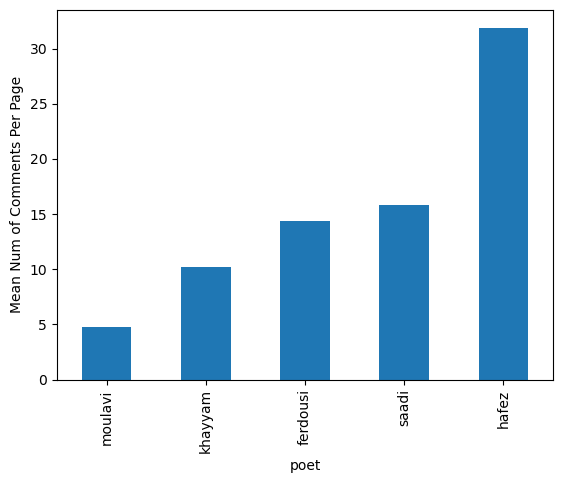

In [291]:
mean_page_comment_poet.plot(kind='bar', ylabel='Mean Num of Comments Per Page', legend=False)

<h2 style='direction:rtl;'> § تحلیل بسامد  </h2> 

<h3>
    کلمه‌بندی متون
</h3>
<div>
    برای تحلیل بسامد، گام نخست، کلمه‌بندی (توکنایز کردن) متن است. هر یک از کامنت‌های گنجور، به توسط ابزار هضم به کلمات تجزیه شدند. دیتای ورودی تابع توکنایزر، دیتای نرمال‌شده قسمت‌های قبل است. 
</div>

In [453]:
from hazm import word_tokenize
df["tokenized_comment"] = df["comment_as_sentences"].apply(lambda sentences: word_tokenize(''.join(sentences))) 

df[["tokenized_comment"]][5:10]

tokenized_comment
5                                                                                                                                                                                                                             [توجه, به, تذکر, شادروان, فروغی, راجع, به, این, دیباچه, در, پاورقی, این, بخش, از, تصحیحش, از, کلیات, سعدی, ضروری, است, :, «, این, دیباچه, بی, هیچ, تردید, از, شیخ, سعدی, نیست, و, چون, در, نسخه‌های, قدیم, و, معتبر, که, ما, در, دست, داریم, نیست, ناگزیر, از, روی, نسخ, چاپی, و, نسخه‌هایی, که, در, حدود, قرن, دهم, کتابت, شده, تصحیح, کردیم, », .]
6  [بنام, خدا, عبارت, «, جل, جلاله, و, عم, نواله, », به, صورتهای, مختلف, در, برخی, خطب, بزرگان, دین, ،, دیده_شده_است, ., مثلا, سید, رضی, به, هنگام, بیان, برخی, از, خطبه‌های, امیرالمومنین, (, ع, ), از, این, تعبیر, استفاده, کرده_است, ., در, آغاز, خطبه, ۸۶, نهج, البلاغه, چنین, گفته_است, :, من, خطبة, له, (, علیه, السلام, ), و, فیها, بیان, صفات, الحق, جل, جلاله, ،, معنای, خبری, عبارت, سعدی, در, آغاز, دیباچه, خود, چنین, است, :, «, بزرگی, و, جلالت, خداوند, عظیم‌تر, از, تصور, است, و, نعمتهای, او, عام, است, و, همه, را, فرا, می‌گیرد, ., », در, واقع, این, عبارت, ...]
7                                                                                                                                                                                                                                                                                   [درود, ., مصرع‌های, دوم, آخرین, دو, بیتی, این, صفحه, جابجا, نوشته, شده, ؛, یعنی, باید, اینچنین, باشد, :, ای, برتر, از, خیال, و, قیاس, و, گمان, و, وهم, وز, هر, چه, گفته‌اند, و, شنیدیم, و, دیده‌ایم, مجلس, تمام, گشت, و, به, آخر, رسید, عمر, ما, همچنان, در, اول, وصف, تو, مانده‌ایم, سپاس, .]
8                                                                                                                                                                                                                                                                                                                                                                                                          [سلام, خسته, نباشید, ., فکر, می‌کنم, در, بیت, آخر, «, به, شیر, », صحیح‌تر, باشد, ., ---, با, تشکر, ،, طبق, پیشنهاد, شما, «, بشیر, », با, «, به, شیر, », جایگزین, شد, .]
9                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [استاد, محمد, رضا, شجریان, در, کاست, فریاد, این, شعر, را, خوانده_است]

<h3>
    حذف Stopwordها
</h3>
<div>
    استاپ‌وردها، کلماتی رایج در زبان هستند که معمولا در تحلیل‌های روی داده‌های متنی، داده معناداری به شمار نمی‌روند. البته «معنادار بودن» این داده‌ها بستگی به سیاق متن دارد. اما به طور کلی، حروف عطف و ربط که در هر زبانی استفاده می‌شوند، در بسیاری از کاربردهای پردازش زبان، از نظر آماری ارزش معناداری ندارند. برای مثال، یک موتور جستجو اصولا نباید برای کلمات عطف و ربط وزن یکسانی با کلمات دیگر که هدف جستجو را مشخص می‌کنند بدهد. در تحلیل بسامد نیز، بسامد کلماتی نظیر «و» و «به» و «از» برای‌مان اهمیت خاصی ندارند، و پیش از تحلیل بسامد باید آن‌ها را حذف کرد.  
</div>
<br/>
<div>
    برای حذف استاپ‌وردها، مطابق قطعه کد زیر از کتاب‌خانه هضم استفاده شده‌است. این کتاب‌خانه یک فهرست پیش‌فرض از استاپ‌وردهای فارسی را در خود دارد. با توجه به اینکه سیاق متن تحلیل‌شده در این تمرین، کامنت‌های توصیفی با لحن نه‌چندان محاوره‌ای می‌باشند، به نظر می‌رسید همین کلمات پیش‌فرض، برای آن‌چه که مد نظر است مناسب باشند. 
</div>

In [565]:
stop_words = hazm.stopwords_list()
' , '.join(stop_words[:50])

'و , در , به , از , که , این , را , با , است , برای , آن , یک , خود , تا , کرد , بر , هم , نیز , گفت , می\u200cشود , وی , شد , دارد , ما , اما , یا , شده , باید , هر , آنها , بود , او , دیگر , دو , مورد , می\u200cکند , شود , کند , وجود , بین , پیش , شده_است , پس , نظر , اگر , همه , یکی , حال , هستند , من'

In [566]:
from hazm import word_tokenize
df["tokenized_comment_stripped"] = df["tokenized_comment"].apply(lambda words: [w for w in words if w not in stop_words]) 

df[["tokenized_comment", "tokenized_comment_stripped"]].iloc()[:3]


tokenized_comment  \
0                                                                                                                                                 [با, درود, خدمت, اساتید, «, آمیزاده, نگه, دار, که, مصحف, ببرد, », به, چه, معناست, ؟, سپاسگزارم]   
1  [محمد, جان, یعنی, ادمیزاد, را, بنگر, که, قران, میدزدد, -, نگه, دار, مانند, گوش, دار, به, معنی, بنگر, است, و, مضمون, بیت, اینست, که, با, انکه, دیو, از, قران, خواندن, میگریزد, پاره‌ای, از, انسانها, چون, از, دستش, اید, حتی, قران, را, میدزدد]   
2                                                         [خزما, از, وی, باز, نستانند, -, درست, ایت, و, نه, باز, ستانند, همانگونه, که, میبینیم, در, اخر, هم, تاکید, کرده, که, فرمود, تا, بها, و, خرما, از, بقالان, باز, نستانند, و, زر, پس, دهند]   

                                                                                                                                          tokenized_comment_stripped  
0                                                                                         [درود, خدمت, اساتید, «, آمیزاده, نگه, مصحف, ببرد, », معناست, ؟, سپاسگزارم]  
1  [محمد, جان, ادمیزاد, بنگر, قران, میدزدد, -, نگه, گوش, معنی, بنگر, مضمون, بیت, اینست, انکه, دیو, قران, خواندن, میگریزد, پاره‌ای, انسانها, دستش, اید, قران, میدزدد]  
2                                                        [خزما, نستانند, -, درست, ایت, ستانند, همانگونه, میبینیم, اخر, تاکید, فرمود, بها, خرما, بقالان, نستانند, زر]

<div>
قطعه‌کد زیر، با استفاده از استاپ‌وردهای هضم، استاپ‌وردهای تمام کامنت‌ها را حذف نموده‌است. مطابق خروجی، توکن‌های فیلترشده ایده‌آل نیستند و همچنان حروف کم‌ارزشی در فهرست کلمات هر کامنت وجود دارند. بنابراین، با قطعه کد زیر، سمبل‌های دیگری به استاپ‌وردها اضافه شد تا تنها کلمات معنادار استخراج شوند. در خروجی تفاوت توکنایز کردن، پس از افزودن استاپ‌وردهای جدید نمایان است. (ستون راست شامل توکن‌های جدید است.) 
</div>

In [567]:
modified_stop_words = hazm.stopwords_list() + [',', '.', ':', '«', '»', '(', ')', '،', '-', '?', '؟', '-']

df["stripped2"] = df["tokenized_comment_stripped"].apply(lambda words: [w for w in words if w not in modified_stop_words]) 

df[["tokenized_comment_stripped", "stripped2"]].iloc()[:3]

tokenized_comment_stripped  \
0                                                                                         [درود, خدمت, اساتید, «, آمیزاده, نگه, مصحف, ببرد, », معناست, ؟, سپاسگزارم]   
1  [محمد, جان, ادمیزاد, بنگر, قران, میدزدد, -, نگه, گوش, معنی, بنگر, مضمون, بیت, اینست, انکه, دیو, قران, خواندن, میگریزد, پاره‌ای, انسانها, دستش, اید, قران, میدزدد]   
2                                                        [خزما, نستانند, -, درست, ایت, ستانند, همانگونه, میبینیم, اخر, تاکید, فرمود, بها, خرما, بقالان, نستانند, زر]   

                                                                                                                                                        stripped2  
0                                                                                               [درود, خدمت, اساتید, آمیزاده, نگه, مصحف, ببرد, معناست, سپاسگزارم]  
1  [محمد, جان, ادمیزاد, بنگر, قران, میدزدد, نگه, گوش, معنی, بنگر, مضمون, بیت, اینست, انکه, دیو, قران, خواندن, میگریزد, پاره‌ای, انسانها, دستش, اید, قران, میدزدد]  
2                                                        [خزما, نستانند, درست, ایت, ستانند, همانگونه, میبینیم, اخر, تاکید, فرمود, بها, خرما, بقالان, نستانند, زر]

<h3>
   تحلیل بسامد کلمات
</h3>
<div>
    پس از نرمال‌سازی، و حذف استاپ‌وردهای کم‌اهمیت، اکنون می‌توانیم تحلیل بسامد را بر روی کامنت‌های صفحات شعر شعرای مختلف اجرا کنیم. قطعه کد زیر، نخست کلمات کامنت‌ها را برای شعرای مختلف گروه‌بندی کرده. سپس، با استفاده از کلاس FreqDist کتاب‌خانه nltk، برای هر شاعر، ۲۵ کلمه پرفرکانس‌ترین استخراج شده‌اند. دیتافریم خروجی، این کلمات را برای هر شاعر نشان می‌دهد.  
</div>
 

In [570]:

from nltk import FreqDist
data_per_poet = df.groupby(by=['poet'])["stripped2"]

# tokenized_comments_dist
tokenized_comments_per_poet = data_per_poet.apply(lambda x: np.array(x, dtype=object))
freq_dist = {}
for poet in data_per_poet:
    # pass
    wlist_poet = list(np.concatenate(tokenized_comments_per_poet[poet[0]]).flatten())
    freq_dist[poet[0]] = FreqDist(wlist_poet).most_common(25)

freq_dist
fdf = pd.DataFrame(freq_dist)
fdf


ferdousi         hafez        khayyam       moulavi         saadi
0       (بیت, 153)   (حافظ, 352)    (خیام, 153)       (…, 79)    (بیت, 194)
1   (شاهنامه, 102)    (بیت, 283)    (رباعی, 90)  (مولانا, 79)   (سعدی, 153)
2     (فردوسی, 90)   (معنی, 153)     (مصرع, 61)     (عشق, 73)       (/, 91)
3       (درست, 66)     (دل, 148)    (زندگی, 53)      (ای, 71)    (معنی, 90)
4          (…, 65)     (سر, 135)        (…, 50)     (بیت, 64)     (شعر, 84)
5          (!, 62)      (!, 118)     (جهان, 50)     (هست, 63)     (عشق, 67)
6       (معنی, 57)  (معشوق, 114)     (دنیا, 46)       (!, 57)       (=, 66)
7       (جهان, 54)     (ای, 113)      (بیت, 45)     (جان, 53)   (استاد, 63)
8          (ز, 54)    (عشق, 111)      (هست, 41)   (انسان, 48)       (…, 63)
9       (زمین, 54)  (انسان, 109)      (شعر, 39)    (معنی, 47)     (شیر, 59)
10       (پای, 47)     (چشم, 96)      (خاک, 38)    (سلام, 45)     (غزل, 59)
11       (گرد, 46)    (عاشق, 95)     (بهشت, 37)    (جهان, 43)       (], 56)
12       (نام, 44)     (غزل, 91)     (معنی, 36)   (میشود, 42)       ([, 54)
13       (کار, 42)     (خدا, 82)       (ای, 36)     (غزل, 42)    (سلام, 51)
14       (شعر, 41)     (زلف, 82)        (ز, 32)      (سر, 39)     (هست, 49)
15      (درود, 40)       (…, 80)      (اون, 30)     (سخن, 37)      (سر, 44)
16        (ان, 40)       (ز, 79)        (!, 30)      (کن, 36)       (ز, 43)
17       (روز, 38)    (مصرع, 73)    (انسان, 29)     (دست, 36)     (جان, 42)
18       (دست, 37)    (جهان, 72)     (صورت, 27)    (زبان, 35)  (دوستان, 41)
19      (زبان, 37)    (حضرت, 70)      (مرگ, 26)     (شمس, 35)    (عاشق, 41)
20      (کلمه, 37)    (دوست, 68)   (دوستان, 25)      (حق, 34)    (حافظ, 40)
21      (مصرع, 35)     (هست, 67)     (سلام, 24)     (شعر, 32)     (دست, 39)
22       (جان, 35)     (لطف, 67)  (رباعیات, 23)    (عزیز, 30)    (مصرع, 39)
23       (سخن, 34)    (سعدی, 63)      (هفت, 23)      (دل, 29)       (!, 38)
24      (سلام, 33)     (دست, 63)      (کاش, 22)    (درست, 28)     (شیخ, 35)

<h3>
    مقایسه ارجاع‌دهی به شعرای مختلف، در کامنت‌های صفحه هر شاعر
</h3>
<div>
    در این قسمت تمرین، با تحلیل متن کامنت‌های روی صفحات شاعران، محاسبه شده که برای هر شاعر، به نام او به طور میانگین چند بار در صفحات شعرای دیگر ارجاع‌دهی شده‌است. این مقدار برای هر جفت شاعران محاسبه می‌شود. داده خروجی این بخش، می‌تواند نمایان‌گر این باشد که در بحث‌های کاربران سایت، کدام شاعران با یکدیگر بیشتر مقایسه می‌شوند. همچنین، شاعرانی که نام‌شان به طور متقابل در صفحات همدیگر به میزان زیادی ارجاع‌دهی شده‌است، احتمالا شباهتی از نظر دوره زندگی شاعر، سبک شعر، و یا محتوای شعر دارند.   
</div>